# Classical art classifier

The aim of this project is to apply image classification in the area of art, learning to comment on subjective and anonymous art pieces. Potentially, the scope of this project can be extended to predict whether an anonymous art belongs to a specific artist.







# Dataset Description

 The dataset is collected from Kaggle titled **Best Artworks of All Time - Collection of Paintings of the 50 Most Influential Artists of All Time.**

 The link can be found here:
 https://www.kaggle.com/datasets/ikarus777/best-artworks-of-all-time

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Basic imports


In [2]:
# Basic Libraries
import os
import numpy as np
import pandas as pd
import tensorflow as tf
# import tensorflow==2.15.0 as tf

# Important submodules and functions from Tensorflow (and Keras)
from tensorflow.keras.layers import Input, Dense, Concatenate, Conv2D, UpSampling2D, Reshape, MaxPooling2D, Lambda, Layer, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.applications import VGG19, Xception, DenseNet121
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from transformers import TFViTForImageClassification, AdamWeightDecay
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping


# Image handling and visualizationv
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
from IPython.display import display
from tqdm.notebook import tqdm
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
# from keras.preprocessing.image import ImageDataGenerator

# Other utility
import datetime
import psutil

# Module settings:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # This will hide all TensorFlow messages, except for errors.
tf.get_logger().setLevel('ERROR')  # This sets TensorFlow logger to only output error messages.

In [3]:
#First mount the csv file
DATASET_PATH = '/content/drive/MyDrive/comp4471/project/dataset'
IMAGE_PATH = '/content/drive/MyDrive/comp4471/project/dataset/images/images'
# Dictionary for all the model paths
MODEL_PATH = {
    "MODEL_SAVE_PATH": '/content/drive/MyDrive/comp4471/project/models/vgg19.h5',
    "MODEL_SAVE_PATH2": '/content/drive/MyDrive/comp4471/project/models/inception.h5',
    "MODEL_SAVE_PATH3": '/content/drive/MyDrive/comp4471/project/models/xception_densenet.h5',
    "MODEL_SAVE_PATH4": '/content/drive/MyDrive/comp4471/project/models/xception_densenet_optimized.h5',
    "MODEL_SAVE_PATH5": '/content/drive/MyDrive/comp4471/project/models/vision_transformers_augmented.keras',
    "MODEL_SAVE_PATH6": '/content/drive/MyDrive/comp4471/project/models/vision_transformers.keras'
}
RESULT_PATH = '/content/drive/MyDrive/comp4471/project/model_results.csv'


Let's visualize the data first!

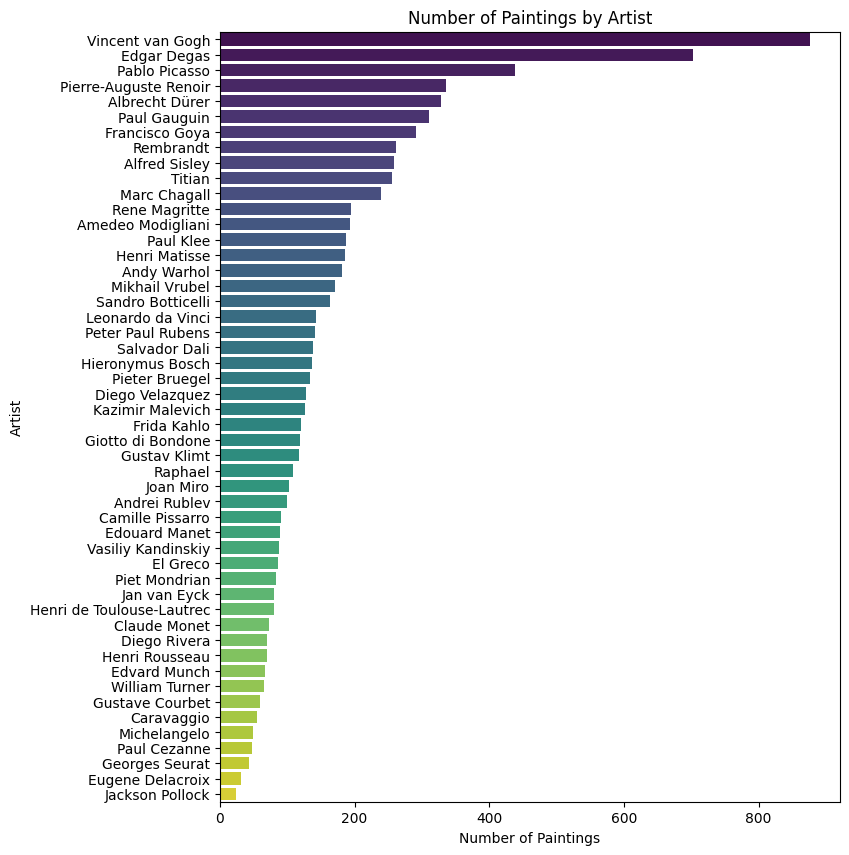

In [5]:
df = pd.read_csv(f"{DATASET_PATH}/artists.csv")
df = df.sort_values('paintings', ascending=False)
# Bar chart to show 'Number of Paintings per Artist'
plt.figure(figsize=(8, 10))
sns.barplot(x='paintings', y='name', data=df, palette='viridis', hue= 'name' )
plt.title('Number of Paintings by Artist')
plt.xlabel('Number of Paintings')
plt.ylabel('Artist')
plt.show()

In the above graph we can see that the dataset contains more paintings from **Vincent van Gogh, Edgar Degas, Pablo Picasso**. Hence, we can first predict that the model might make mistakes due to the imbalance of the data.

In [6]:
df.head()

id                   name        years                 genre nationality  \
8    8       Vincent van Gogh  1853 – 1890    Post-Impressionism       Dutch   
30  30            Edgar Degas  1834 - 1917         Impressionism      French   
13  13          Pablo Picasso  1881 - 1973                Cubism     Spanish   
15  15  Pierre-Auguste Renoir  1841 - 1919         Impressionism      French   
19  19         Albrecht Dürer  1471 - 1528  Northern Renaissance      German   

                                                  bio  \
8   Vincent Willem van Gogh (Dutch: [ˈvɪnsɛnt ˈʋɪl...   
30  Edgar Degas (US:  or UK: ; born Hilaire-Germai...   
13  Pablo Ruiz Picasso (; Spanish: [ˈpaβlo piˈkaso...   
15  Pierre-Auguste Renoir, commonly known as Augus...   
19  Albrecht Dürer (; German: [ˈʔalbʁɛçt ˈdyːʁɐ]; ...   

                                            wikipedia  paintings  
8       http://en.wikipedia.org/wiki/Vincent_van_Gogh        877  
30           http://en.wikipedia.org/wiki/Edgar_Degas        702  
13         http://en.wikipedia.org/wiki/Pablo_Picasso        439  
15  http://en.wikipedia.org/wiki/Pierre-Auguste_Re...        336  
19        http://en.wikipedia.org/wiki/Albrecht_Dürer        328

In [7]:
# make three lists artist_list, artist_to_genre, genre_list
artist_list = df['name'].tolist()
artist_to_genre = dict(zip(df['name'], df['genre']))  # Dictionary mapping each artist to their genre
genre_list = df['genre'].unique().tolist()  # List of unique genres

print("Artist List:", artist_list)
print("The number of the given artists is "+ str(len(artist_list)))
print("Artist to Genre Mapping:", artist_to_genre)
print("Genre List:", genre_list)

Artist List: ['Vincent van Gogh', 'Edgar Degas', 'Pablo Picasso', 'Pierre-Auguste Renoir', 'Albrecht Dürer', 'Paul Gauguin', 'Francisco Goya', 'Rembrandt', 'Alfred Sisley', 'Titian', 'Marc Chagall', 'Rene Magritte', 'Amedeo Modigliani', 'Paul Klee', 'Henri Matisse', 'Andy Warhol', 'Mikhail Vrubel', 'Sandro Botticelli', 'Leonardo da Vinci', 'Peter Paul Rubens', 'Salvador Dali', 'Hieronymus Bosch', 'Pieter Bruegel', 'Diego Velazquez', 'Kazimir Malevich', 'Frida Kahlo', 'Giotto di Bondone', 'Gustav Klimt', 'Raphael', 'Joan Miro', 'Andrei Rublev', 'Camille Pissarro', 'Edouard Manet', 'Vasiliy Kandinskiy', 'El Greco', 'Piet Mondrian', 'Jan van Eyck', 'Henri de Toulouse-Lautrec', 'Claude Monet', 'Diego Rivera', 'Henri Rousseau', 'Edvard Munch', 'William Turner', 'Gustave Courbet', 'Caravaggio', 'Michelangelo', 'Paul Cezanne', 'Georges Seurat', 'Eugene Delacroix', 'Jackson Pollock']
The number of the given artists is 50
Artist to Genre Mapping: {'Vincent van Gogh': 'Post-Impressionism', 'Edga

**Error in dataset**

Apparently, there is a mismatch between the dataset and the csv file. Analyzing the csv file, that there are 50 artists, however, the image file contains only 49 artists.

The artist "Albrecht_Dürer" does not exists. Hence, let's update the variables so that it matches the actual data.

In [8]:
for artist in artist_list:
    formatted_artist = artist.replace(' ', '_')
    current_path = f"{IMAGE_PATH}/{formatted_artist}"
    if os.path.exists(current_path):
      continue
    else:
      print(f"The artist '{artist}' doesn't exist.")
      artist_list.remove(artist)


The artist 'Albrecht Dürer' doesn't exist.


In [9]:
print(artist_list)

['Vincent van Gogh', 'Edgar Degas', 'Pablo Picasso', 'Pierre-Auguste Renoir', 'Paul Gauguin', 'Francisco Goya', 'Rembrandt', 'Alfred Sisley', 'Titian', 'Marc Chagall', 'Rene Magritte', 'Amedeo Modigliani', 'Paul Klee', 'Henri Matisse', 'Andy Warhol', 'Mikhail Vrubel', 'Sandro Botticelli', 'Leonardo da Vinci', 'Peter Paul Rubens', 'Salvador Dali', 'Hieronymus Bosch', 'Pieter Bruegel', 'Diego Velazquez', 'Kazimir Malevich', 'Frida Kahlo', 'Giotto di Bondone', 'Gustav Klimt', 'Raphael', 'Joan Miro', 'Andrei Rublev', 'Camille Pissarro', 'Edouard Manet', 'Vasiliy Kandinskiy', 'El Greco', 'Piet Mondrian', 'Jan van Eyck', 'Henri de Toulouse-Lautrec', 'Claude Monet', 'Diego Rivera', 'Henri Rousseau', 'Edvard Munch', 'William Turner', 'Gustave Courbet', 'Caravaggio', 'Michelangelo', 'Paul Cezanne', 'Georges Seurat', 'Eugene Delacroix', 'Jackson Pollock']


# Preprocessing data and basic setups

There are several things we want to do here:
1. Create 2 dataframes, img to path & genre to path
2. Define the utility functions do preprocess the image and depreocess the img
3. Prepare the initialized the dataset
4. Analyze the dataset that we have

## Dataframe creation
Create a dataframe with all the images & genres with the corresponding paths for easier training later on.


In [ ]:
def createDataFrame():
  table = pd.DataFrame()
  table['label'] = None
  table['image_path'] = None

  for artist in artist_list:
    formatted_artist = artist.replace(' ', '_')
    current_path = f"{IMAGE_PATH}/{formatted_artist}"
    for file_name in os.listdir(current_path):
      if file_name.endswith(('.jpg', '.png', '.jpeg')):  # Assuming image files have these extensions
          image_path = os.path.join(current_path, file_name)
          img = cv2.imread(image_path)
          if(img is not None):
            value = {
                'label': artist,
                'image_path': image_path
            }
            # Append to the dataframe the label name and the image path
            table = pd.concat([table, pd.DataFrame([value])],  ignore_index=True)
  return table


In [ ]:
# For the following three blockss do not reload if necessary
dataframe = createDataFrame()

In [ ]:
dataframe.head()

label                                         image_path
0  Vincent van Gogh  /content/drive/MyDrive/comp4471/project/datase...
1  Vincent van Gogh  /content/drive/MyDrive/comp4471/project/datase...
2  Vincent van Gogh  /content/drive/MyDrive/comp4471/project/datase...
3  Vincent van Gogh  /content/drive/MyDrive/comp4471/project/datase...
4  Vincent van Gogh  /content/drive/MyDrive/comp4471/project/datase...

Download the dataframe as csv so that we don't have to create a new dataframe everytime.

In [ ]:
dataframe.to_csv(f"{DATASET_PATH}/artist_to_path.csv", index=False)

Create a dataframe with genre to corresponding paintings

In [ ]:
def createGenreDataFrame():
  table = pd.DataFrame()
  table['label'] = None
  table['image_path'] = None
  table['artist'] = None

  for artist in artist_list:
    artist_genre_type = artist_to_genre.get(artist, "Artist not found")
    formatted_artist = artist.replace(' ', '_')
    current_path = f"{IMAGE_PATH}/{formatted_artist}"
    for file_name in os.listdir(current_path):
      if file_name.endswith(('.jpg', '.png', '.jpeg')):  # Assuming image files have these extensions
          image_path = os.path.join(current_path, file_name)
          img = cv2.imread(image_path)
          if(img is not None):
            value = {
                'label': artist_genre_type,
                'artist': artist,
                'image_path': image_path
            }
            # Append to the dataframe the label name and the image path
            table = pd.concat([table, pd.DataFrame([value])],  ignore_index=True)
  return table


In [ ]:
# For the following three blockss do not reload if necessary
genredataframe = createGenreDataFrame()

In [ ]:
genredataframe.head()

label                                         image_path  \
0  Post-Impressionism  /content/drive/MyDrive/comp4471/project/datase...   
1  Post-Impressionism  /content/drive/MyDrive/comp4471/project/datase...   
2  Post-Impressionism  /content/drive/MyDrive/comp4471/project/datase...   
3  Post-Impressionism  /content/drive/MyDrive/comp4471/project/datase...   
4  Post-Impressionism  /content/drive/MyDrive/comp4471/project/datase...   

             artist  
0  Vincent van Gogh  
1  Vincent van Gogh  
2  Vincent van Gogh  
3  Vincent van Gogh  
4  Vincent van Gogh

In [ ]:
genredataframe.to_csv(f"{DATASET_PATH}/genre_to_path.csv", index=False)

## Utility Functions

In [10]:
# Prepares an image for the model by converting RGB to BGR and subtracting the mean pixel values.
def preprocess(x):
    img = tf.reverse(x, axis=[-1])  # RGB to BGR
    img -= np.array([103.939, 116.779, 123.68])  # Subtract mean pixel value
    return img

# Converts the output of the model back to a viewable image by adding mean pixel values and converting BGR to RGB.
def deprocess(x):
    img = x + np.array([103.939, 116.779, 123.68])  # Add mean pixel value
    img = tf.reverse(img, axis=[-1])  # BGR to RGB
    img = tf.clip_by_value(img, 0.0, 255.0)  # Ensure pixel value range is valid
    return img

# Loads an image from disk, optionally resizes it, and prepares it for the model.
def get_image(img_path, resize=True, shape=(256,256)):
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR (OpenCV default) to RGB
    if resize:
        image = cv2.resize(image, shape)  # Resize image
    image = image.astype(np.float32)  # Convert to float32 for model compatibility
    return image

# Finds and returns a list of images (files) within a directory path that matches a certain file type.
def find_images(dir_path, file_type):
    image_paths = []

    for root, _, files in os.walk(dir_path):
        for file in files:
            if f'.{file_type}' in file:
                image_paths.append(os.path.join(root, file))

    return image_paths


## Classification Dataset Setup



In [ ]:
Label_To_Int = {artist: index for index, artist in enumerate(artist_list)}
print(Label_To_Int)

{'Vincent van Gogh': 0, 'Edgar Degas': 1, 'Pablo Picasso': 2, 'Pierre-Auguste Renoir': 3, 'Paul Gauguin': 4, 'Francisco Goya': 5, 'Rembrandt': 6, 'Alfred Sisley': 7, 'Titian': 8, 'Marc Chagall': 9, 'Rene Magritte': 10, 'Amedeo Modigliani': 11, 'Paul Klee': 12, 'Henri Matisse': 13, 'Andy Warhol': 14, 'Mikhail Vrubel': 15, 'Sandro Botticelli': 16, 'Leonardo da Vinci': 17, 'Peter Paul Rubens': 18, 'Salvador Dali': 19, 'Hieronymus Bosch': 20, 'Pieter Bruegel': 21, 'Diego Velazquez': 22, 'Kazimir Malevich': 23, 'Frida Kahlo': 24, 'Giotto di Bondone': 25, 'Gustav Klimt': 26, 'Raphael': 27, 'Joan Miro': 28, 'Andrei Rublev': 29, 'Camille Pissarro': 30, 'Edouard Manet': 31, 'Vasiliy Kandinskiy': 32, 'El Greco': 33, 'Piet Mondrian': 34, 'Jan van Eyck': 35, 'Henri de Toulouse-Lautrec': 36, 'Claude Monet': 37, 'Diego Rivera': 38, 'Henri Rousseau': 39, 'Edvard Munch': 40, 'William Turner': 41, 'Gustave Courbet': 42, 'Caravaggio': 43, 'Michelangelo': 44, 'Paul Cezanne': 45, 'Georges Seurat': 46, 'Eu

In [ ]:
class ClassificationDataset:
    def __init__(self, dataset_panda_frame, batch_size=8, random_state = 4711):
        self.batch_size = batch_size
        self.random_state = random_state


        ###Create panda dataframe that contains two columns, the first is the animal name, the second is the path.
        self.data_table = dataset_panda_frame #TODO
        self.total_samples = len(self.data_table)
        self.unique_labels = self.data_table['label'].unique()


        ## For handling shuffling
        self.indices = np.arange(self.total_samples)


        self.ds_pointer = 0

    def getImagePathByIndex(self, index):
      row = self.data_table.iloc[index]
      return row["image_path"]


    def getClassStringBasedOnOneHotIndex(self, index): #eg if pass in 4, map to [0,0,0,0,1], map to "dog"
      return self.unique_labels[index]

    def getNumLabels(self):
      return (len(self.unique_labels))

    def reset_pointer(self, seed=None):
        self.ds_pointer = 0
        np.random.seed(seed)
        np.random.shuffle(self.indices)


    def get_batch(self):
        if self.ds_pointer + self.batch_size >= self.total_samples:
            self.reset_pointer()

        batch_images = []


        for i in range(self.batch_size):
            index = self.indices[self.ds_pointer]
            row = self.data_table.iloc[index]
            image_label = row['label']
            image_path = row['image_path']

            #Before
            class_to_index = {class_label: index for index, class_label in enumerate(self.unique_labels)}
            image_label = class_to_index[image_label]

            image = get_image(image_path)
            pre_processed_image = preprocess(image)

            batch_images.append((pre_processed_image,tf.one_hot(image_label, len(self.unique_labels))))
            self.ds_pointer += 1

        return batch_images

    def returnTsvPd(self):
      return self.data_table

    def getUniqueTypes(self):
      return self.unique_labels

    def getNumSamples(self):
      return self.total_samples

    def getAllImagesPaths(self):
      return self.data_table["image_path"].values()

    def __len__(self):
        return  int(np.ceil(self.total_samples/self.batch_size))

In [ ]:
# Get the dataframe from google drive that we last saved
# Load the dataset
dataframe = pd.read_csv(f"{DATASET_PATH}/artist_to_path.csv")

In [ ]:
# Split the panda dataframe into train_pd and test_pd
random_state = 4471
train_df, test_df = train_test_split(dataframe, test_size=0.2, random_state=random_state)
# Split the train_df dataframe into train_pd and val_df
train_df, val_df = train_test_split(train_df, test_size=0.25, random_state=random_state)

## Initializing Dataset

In [11]:
def prepare_datasets(training_df, testing_df, validation_df):
    #####
    # Our settings here
    #####
    BATCH_SIZE = 32
    train_dataset = ClassificationDataset(dataset_panda_frame = training_df,batch_size = BATCH_SIZE)
    test_dataset = ClassificationDataset(dataset_panda_frame = testing_df,batch_size = BATCH_SIZE)
    validation_df = ClassificationDataset(dataset_panda_frame = validation_df,batch_size = BATCH_SIZE)
    return train_dataset,test_dataset, validation_df

In [ ]:
train_dataset, test_dataset, val_dataset = prepare_datasets(training_df = train_df, testing_df = test_df, validation_df = val_df)

## Analyze Dataset

In [ ]:
def tally_samples(dataset):
    tally = {}
    data_table = dataset.returnTsvPd()
    for _, row in data_table.iterrows():
        path = row['image_path']
        label = row['label']
        if label not in tally:
            tally[label] = 0
        tally[label] += 1
    print("Tally of samples for each label:")
    for label, count in tally.items():
        print(label, ": ", count)
    return tally

In [ ]:
temp = tally_samples(train_dataset)

Tally of samples for each label:
Titian :  153
Marc Chagall :  153
Francisco Goya :  178
Raphael :  64
Henri Rousseau :  46
Gustav Klimt :  65
Andy Warhol :  107
Edgar Degas :  424
Paul Gauguin :  191
Claude Monet :  51
Vincent van Gogh :  524
Alfred Sisley :  161
Diego Velazquez :  73
Pablo Picasso :  253
Kazimir Malevich :  75
Henri Matisse :  114
Leonardo da Vinci :  90
Peter Paul Rubens :  84
Paul Klee :  107
Pieter Bruegel :  78
Amedeo Modigliani :  114
Mikhail Vrubel :  104
Salvador Dali :  74
Joan Miro :  58
Rene Magritte :  118
Andrei Rublev :  68
Giotto di Bondone :  78
Frida Kahlo :  78
Pierre-Auguste Renoir :  210
Rembrandt :  150
Hieronymus Bosch :  83
Diego Rivera :  45
Edvard Munch :  43
Camille Pissarro :  61
Vasiliy Kandinskiy :  47
Eugene Delacroix :  24
Sandro Botticelli :  94
Michelangelo :  37
Henri de Toulouse-Lautrec :  46
Caravaggio :  35
Paul Cezanne :  33
Edouard Manet :  52
Georges Seurat :  30
Gustave Courbet :  28
William Turner :  32
El Greco :  49
Jan van 

In [ ]:
temp = tally_samples(test_dataset)

Tally of samples for each label:
Henri de Toulouse-Lautrec :  14
Henri Matisse :  39
Edgar Degas :  165
Marc Chagall :  40
Sandro Botticelli :  32
Frida Kahlo :  25
Eugene Delacroix :  3
Paul Klee :  36
Edouard Manet :  19
Francisco Goya :  54
Kazimir Malevich :  23
Salvador Dali :  32
Georges Seurat :  6
Paul Gauguin :  57
Pierre-Auguste Renoir :  69
El Greco :  18
Vincent van Gogh :  177
Pablo Picasso :  90
Leonardo da Vinci :  25
Rembrandt :  58
Joan Miro :  24
Piet Mondrian :  14
Titian :  57
Michelangelo :  10
Mikhail Vrubel :  29
William Turner :  16
Diego Velazquez :  31
Camille Pissarro :  15
Raphael :  24
Jackson Pollock :  6
Amedeo Modigliani :  47
Diego Rivera :  12
Rene Magritte :  45
Gustave Courbet :  20
Hieronymus Bosch :  24
Jan van Eyck :  20
Andy Warhol :  42
Gustav Klimt :  23
Peter Paul Rubens :  27
Edvard Munch :  9
Andrei Rublev :  16
Alfred Sisley :  44
Vasiliy Kandinskiy :  17
Claude Monet :  9
Paul Cezanne :  8
Henri Rousseau :  12
Pieter Bruegel :  29
Caravagg

In [ ]:
temp = tally_samples(val_dataset)

Tally of samples for each label:
Francisco Goya :  59
Giotto di Bondone :  28
Caravaggio :  13
Gustave Courbet :  11
Mikhail Vrubel :  38
Henri de Toulouse-Lautrec :  21
Peter Paul Rubens :  30
Gustav Klimt :  29
William Turner :  18
Edgar Degas :  143
Vasiliy Kandinskiy :  24
Hieronymus Bosch :  30
Andrei Rublev :  15
Leonardo da Vinci :  28
Paul Gauguin :  63
Edouard Manet :  19
Vincent van Gogh :  186
Rene Magritte :  31
Diego Rivera :  13
Paul Cezanne :  6
Marc Chagall :  46
Pieter Bruegel :  27
Paul Klee :  45
Pablo Picasso :  96
Salvador Dali :  33
Sandro Botticelli :  38
Titian :  45
Henri Matisse :  33
Alfred Sisley :  54
Camille Pissarro :  15
Rembrandt :  54
Pierre-Auguste Renoir :  57
Kazimir Malevich :  28
Andy Warhol :  32
El Greco :  20
Claude Monet :  13
Amedeo Modigliani :  32
Georges Seurat :  7
Raphael :  21
Frida Kahlo :  17
Piet Mondrian :  21
Joan Miro :  20
Edvard Munch :  15
Jan van Eyck :  11
Henri Rousseau :  12
Diego Velazquez :  24
Jackson Pollock :  5
Eugene

# Model setup

In [ ]:

def build_vgg19_classifier(input_shape, num_class):
    # Create vgg19 structure
    model = Sequential()

    # Convolutional layers
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2))

    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2))

    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2))

    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))

    # Additional layers
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1024, activation='relu', name='dense1'))
    model.add(Dense(1024, activation='relu',  name='dense2'))
    model.add(Dense(512, activation='relu', name='dense3'))
    model.add(Dense(num_class, activation='softmax',  name='dense4'))

    print("Report for vgg 19 classifier")
    model.summary()

    return model

In [ ]:
# building a inception model inspired by google
def inception_module(x, filters):
    # Define the different branches in the inception module
    conv1 = Conv2D(filters, kernel_size=1, padding='same', activation='relu')(x)
    conv3 = Conv2D(filters, kernel_size=3, padding='same', activation='relu')(x)
    conv5 = Conv2D(filters, kernel_size=5, padding='same', activation='relu')(x)

    # Pooling branch
    pool = MaxPooling2D(pool_size=3, strides=1, padding='same')(x)
    pool = Conv2D(filters, kernel_size=1, padding='same', activation='relu')(pool)

    # Concatenate all branches along the last axis
    return Concatenate(axis=-1)([conv1, conv3, conv5, pool])

def build_inception_classifier(input_shape, num_class):
    # Define input layer
    inputs = Input(shape=input_shape)

    # Initial convolution and pooling layers
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D(pool_size=(2, 2), strides=2)(x)

    # First Inception module
    x = inception_module(x, 64)
    x = MaxPooling2D(pool_size=(2, 2), strides=2)(x)

    # Second Inception module
    x = inception_module(x, 128)

    # Global average pooling and dense layers for classification
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    outputs = Dense(num_class, activation='softmax')(x)

    # Create the model
    model = Model(inputs=inputs, outputs=outputs)

    # Print the model summary
    model.summary()

    return model

In [ ]:
def build_xception_densenet_classifier(input_shape, num_class):
    # Define input
    inputs = Input(shape=input_shape)

    # Load Xception model without the top layer
    xception_model = Xception(include_top=False, weights='imagenet', input_tensor=inputs)
    for layer in xception_model.layers[-30:]:
        layer.trainable = True
    # for layer in xception_model.layers:
    #     layer.trainable = False  # Freeze layers for feature extraction
    xception_features = GlobalAveragePooling2D()(xception_model.output)

    # Load DenseNet121 model without the top layer
    densenet_model = DenseNet121(include_top=False, weights='imagenet', input_tensor=inputs)
    for layer in densenet_model.layers[-30:]:
        layer.trainable = True
    # for layer in densenet_model.layers:
    #     layer.trainable = False  # Freeze layers for feature extraction
    densenet_features = GlobalAveragePooling2D()(densenet_model.output)

    # Concatenate features from both models
    combined_features = Concatenate()([xception_features, densenet_features])

    # Add a classification head
    x = Dense(1024, activation='relu')(combined_features)
    x = Dense(512, activation='relu')(x)
    outputs = Dense(num_class, activation='softmax')(x)  # Adjust to the number of classes

    # Define the model
    model = Model(inputs=inputs, outputs=outputs)

    # Model summary
    model.summary()

    return model


In [ ]:
def model_setup(current_dataset, LOAD_PATH=None, model_type='VGG19'):
    # Set input shape (typical input for pretrained models)
    INPUT_SHAPE = (None, None, 3)
    NUM_CLASS = current_dataset.getNumLabels()

    # Build model based on model type
    if model_type == 'VGG19':
        model = build_vgg19_classifier(INPUT_SHAPE, NUM_CLASS)
    elif model_type == 'Inception':
        model = build_inception_classifier(INPUT_SHAPE, NUM_CLASS)
    elif model_type == 'xceptiondense':
        model = build_xception_densenet_classifier(INPUT_SHAPE, NUM_CLASS)
    else:
        model = build_xception_densenet_classifier(INPUT_SHAPE, NUM_CLASS)
        # raise ValueError("Model type not recognized. Please choose 'VGG19' or 'Inception'.")

    # Define the loss function
    loss_fn = tf.keras.losses.CategoricalCrossentropy()

    # Load model weights if LOAD_PATH is specified
    if LOAD_PATH:
        model.load_weights(LOAD_PATH)
        print(f"Weights loaded from {LOAD_PATH}")

    return model, loss_fn


# Training to classify Artists

In [ ]:
# Let's first run the model with VGG19
model, loss = model_setup(train_dataset)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Report for vgg 19 classifier


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, None, None, 64)      │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, None, None, 64)      │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, None, None, 64)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, None, None, 128)     │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, None, None, 128)     │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, None, None, 128)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, None, None, 256)     │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, None, None, 256)     │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, None, None, 256)     │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, None, None, 256)     │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, None, None, 256)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, None, None, 512)     │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense1 (Dense)                       │ (None, 1024)                │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense2 (Dense)                       │ (None, 1024)                │       1,049,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense3 (Dense)                       │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense4 (Dense)                       │ (None, 49)                  │          25,137 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,630,577 (21.48 MB)

 Trainable params: 5,630,577 (21.48 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
def model_train(model, train_dataset, val_dataset, loss_fn, n_epochs=100, save_interval=10, save_path=None, load_path=None, optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4, weight_decay=1e-5)):
    # Initialize the Optimizer
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

    # Calculate the number of batches per epoch for training
    n_batches = len(train_dataset)

    best_val_loss = float('inf')  # Set the best validation loss to infinity initially
    epochs_without_improvement = 0

    # Load weights if provided
    if load_path:
        model.load_weights(load_path)

    # Run for n epochs
    for e in range(1, n_epochs + 1):
        pbar = tqdm(total=n_batches, desc=f"Epoch {e}/{n_epochs}")
        # Reset Dataset Iterators
        train_dataset.reset_pointer()

        # Define Loss Metrics for training and validation
        train_losses = {"cross-entropy": 0.0}
        val_losses = {"cross-entropy": 0.0}
        val_accuracy = 0.0

        # --- Training Loop ---
        for i in range(n_batches):
            # Fetch Training Batches
            batch_images = train_dataset.get_batch()
            images, labels = zip(*batch_images)
            images = np.array(images)
            labels = np.array(labels)

            # Execute Batch Training
            with tf.GradientTape() as tape:
                logits = model(images, training=True)
                logits = tf.clip_by_value(logits, 1e-7, 1 - 1e-7)
                loss = loss_fn(labels, logits)

            gradients = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))

            # Update Training Loss Metrics
            train_losses["cross-entropy"] += loss.numpy()

            # Update Progress Bar
            pbar.set_description(f"Epoch {e}/{n_epochs} | Train Loss: {train_losses['cross-entropy'] / (i+1):.3f}")
            pbar.update(1)

        # --- Validation Loop ---
        val_batches = len(val_dataset)
        val_dataset.reset_pointer()
        for k in range(val_batches):
            val_batch = val_dataset.get_batch()
            images, labels = zip(*val_batch)
            images = np.array(images)
            labels = np.array(labels)

            # Compute Validation Loss and Accuracy
            val_logits = model(images, training=False)
            val_loss = loss_fn(labels, val_logits)
            val_losses["cross-entropy"] += val_loss.numpy()

            # Calculate accuracy for this batch
            val_predictions = tf.argmax(val_logits, axis=1)
            val_true = tf.argmax(labels, axis=1)
            batch_accuracy = tf.reduce_mean(tf.cast(val_predictions == val_true, tf.float32))
            val_accuracy += batch_accuracy.numpy()

        # Average validation loss and accuracy
        val_loss_avg = val_losses["cross-entropy"] / len(val_dataset)
        val_accuracy_avg = val_accuracy / len(val_dataset)

        # Early stopping check
        if val_loss_avg < best_val_loss:
            best_val_loss = val_loss_avg
            epochs_without_improvement = 0  # Reset the counter since there's improvement
        else:
            epochs_without_improvement += 1

        # Stop training if no improvement for 'patience' epochs
        if epochs_without_improvement >= 5:
            print(f"Early stopping: Validation loss did not improve for 5 epochs.")
            break

        # Display validation results
        print(f"Validation Loss: {val_loss_avg:.3f} | Validation Accuracy: {val_accuracy_avg:.3%}")

        # Save model periodically
        if e % save_interval == 0:
            if save_path:
                model.save(save_path)

        pbar.close()


In [ ]:
def evaluate(model, dataset):
     # Calculate and accumulate the accuracy of the model across all batches in the given dataset.
    total_samples = 0
    correct_predictions = 0
    incorrect_printing_counter = 0
    dataset.reset_pointer()

    # Calculate the confusion matrix of the model on the given dataset.
    num_classes = dataset.getNumLabels()
    confusion_matrix = np.zeros((num_classes, num_classes), dtype=np.int32)

    n_batches = len(dataset)
    r_counter = 0

    for i in range(n_batches):
        batch_images = dataset.get_batch()
        images, labels = zip(*batch_images)
        images = np.array(images)
        labels = np.array(labels)


        # Predict labels using the model
        logits = model.predict(images)
        # predictions = tf.argmax(logits, axis=-1)
        predictions = tf.argmax(logits, axis=-1, output_type=tf.int32)

        # Update accuracy
        total_samples += labels.shape[0]


        # Run through the batch, Update confusion matrix
        for j in range(labels.shape[0]):

            true_label = np.argmax(labels[j])#.numpy()
            predicted_label = predictions[j].numpy()
            if true_label == (predicted_label):
              correct_predictions += 1
            confusion_matrix[true_label, predicted_label] += 1


            ##Printing three incorrect guess
            if incorrect_printing_counter < 20 and true_label != predicted_label:
              current_image = images[j]
              de_pre_processed_image = deprocess(current_image)
              img = array_to_img(de_pre_processed_image)
              display(img)
              predicted_label_string = dataset.getClassStringBasedOnOneHotIndex(predicted_label)
              true_label_string = dataset.getClassStringBasedOnOneHotIndex(true_label)
              print(f"Oops! The predicted was: {predicted_label_string}, but the true was: {true_label_string}")
              incorrect_printing_counter += 1

    accuracy = correct_predictions / total_samples

    return accuracy, confusion_matrix


## Train with Updated VGG19

Trainng on 49 different labels

In [ ]:
model_train(model, train_dataset, loss, n_epochs = 60, save_interval = 10, save_path = MODEL_PATH['MODEL_SAVE_PATH'] )

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
#In case it crashes let's continue here:
remaining_epoch = 49
model, loss = model_setup(current_dataset = train_dataset, LOAD_PATH= MODEL_PATH['MODEL_SAVE_PATH'])
model_train(model, train_dataset, loss, n_epochs = remaining_epoch, save_interval = 10, save_path=MODEL_PATH['MODEL_SAVE_PATH'],load_path=MODEL_PATH['MODEL_SAVE_PATH'])

Report for vgg 19 classifier


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)                    │ (None, None, None, 64)      │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, None, None, 64)      │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, None, None, 64)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, None, None, 128)     │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, None, None, 128)     │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, None, None, 128)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, None, None, 256)     │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, None, None, 256)     │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, None, None, 256)     │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, None, None, 256)     │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, None, None, 256)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, None, None, 512)     │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense1 (Dense)                       │ (None, 1024)                │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense2 (Dense)                       │ (None, 1024)                │       1,049,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense3 (Dense)                       │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense4 (Dense)                       │ (None, 49)                  │          25,137 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,630,577 (21.48 MB)

 Trainable params: 5,630,577 (21.48 MB)

 Non-trainable params: 0 (0.00 B)

Weights loaded from /content/drive/MyDrive/comp4211/Project/Model/vgg19.h5
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step


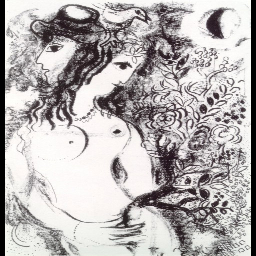

Oops!, The predicted was: Henri de Toulouse-Lautrec, but the true was: Marc Chagall


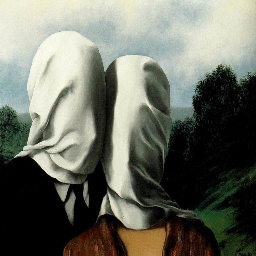

Oops!, The predicted was: Diego Rivera, but the true was: Rene Magritte


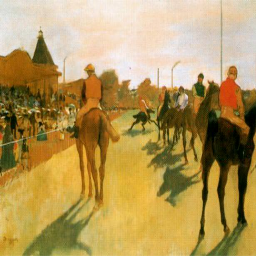

Oops!, The predicted was: Marc Chagall, but the true was: Edgar Degas
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━

In [ ]:
#TESTING AGAINST TEST DS
model, loss = model_setup(current_dataset = train_dataset, LOAD_PATH= MODEL_PATH['MODEL_SAVE_PATH'])
accuracy, confusion_matrix_data = evaluate(model, test_dataset)

Accuracy: 0.019230769230769232
Confusion Matrix:


([<matplotlib.axis.YTick at 0x7f2bd05492d0>,
 [Text(0, 0, 'Henri de Toulouse-Lautrec'),
  Text(0, 1, 'Henri Matisse'),
  Text(0, 2, 'Edgar Degas'),
  Text(0, 3, 'Marc Chagall'),
  Text(0, 4, 'Sandro Botticelli'),
  Text(0, 5, 'Frida Kahlo'),
  Text(0, 6, 'Eugene Delacroix'),
  Text(0, 7, 'Paul Klee'),
  Text(0, 8, 'Edouard Manet'),
  Text(0, 9, 'Francisco Goya'),
  Text(0, 10, 'Kazimir Malevich'),
  Text(0, 11, 'Salvador Dali'),
  Text(0, 12, 'Georges Seurat'),
  Text(0, 13, 'Paul Gauguin'),
  Text(0, 14, 'Pierre-Auguste Renoir'),
  Text(0, 15, 'El Greco'),
  Text(0, 16, 'Vincent van Gogh'),
  Text(0, 17, 'Pablo Picasso'),
  Text(0, 18, 'Leonardo da Vinci'),
  Text(0, 19, 'Rembrandt'),
  Text(0, 20, 'Joan Miro'),
  Text(0, 21, 'Piet Mondrian'),
  Text(0, 22, 'Titian'),
  Text(0, 23, 'Michelangelo'),
  Text(0, 24, 'Mikhail Vrubel'),
  Text(0, 25, 'William Turner'),
  Text(0, 26, 'Diego Velazquez'),
  Text(0, 27, 'Camille Pissarro'),
  Text(0, 28, 'Raphael'),
  Text(0, 29, 'Jackson Pollo

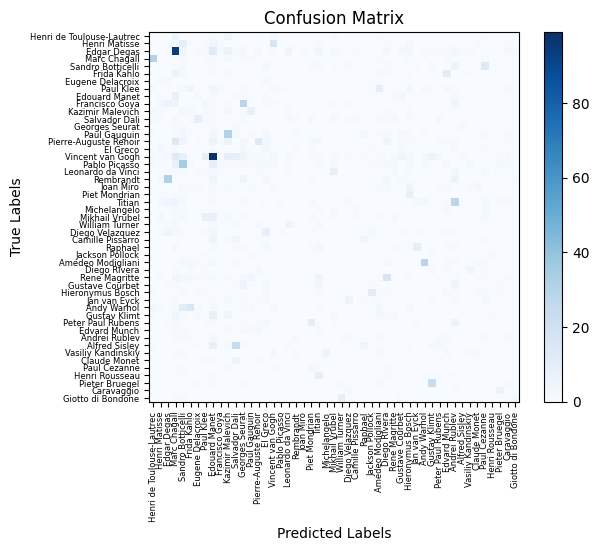

In [ ]:
print("Accuracy:", accuracy)
print("Confusion Matrix:")
unique_types = test_dataset.getUniqueTypes()
num_classes = test_dataset.getNumLabels()
tick_locations = range(len(unique_types))

plt.imshow(confusion_matrix_data, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.colorbar()

plt.xticks(tick_locations, unique_types, rotation='vertical', fontsize=6)
plt.yticks(tick_locations, unique_types, fontsize=6)

As the accuracy was only 1.9%, it can be seen that one artist may have different styles over the course of their lives. As such, styles, images, characters, etc will cause the distortion and the lower accuracy during prediction.

## Model - Combining Xception Model with DenseNet


The general idea is to design a Multi-Task Network Architecture: using a concatenated feature extractor, utilizing pretrained weights learning the weights from dense layer, and make image predictions.

As some of the artist have really small datasets, e.g. 35 images, while the others have up to 800 paintings, this will cause a huge bias in the model. Hence, we will now remove the artists that have less than 1/5 of the artists who have the max paintings - Vincent van Gogh.



In [ ]:
# Get the dataframe from google drive that we last saved
# Load the dataset
dataframe = pd.read_csv(f"{DATASET_PATH}/artist_to_path.csv")

now modify to get the artists that have enough paintings in our dataset

In [ ]:
# Identify the maximum number of paintings
max_paintings = df['paintings'].max()

# Calculate the threshold (1/4 of the maximum number of paintings)
threshold = max_paintings / 5

# Filter out artists with fewer paintings than the threshold
filtered_df = df[df['paintings'] >= threshold]

print(f"Original number of artists: {len(df)}")
print(f"Number of artists after filtering: {len(filtered_df)}")

Original number of artists: 50
Number of artists after filtering: 16


so this these are the actual artists that we will be training

In [ ]:
new_artist_list = filtered_df['name'].unique().tolist()  # List of unique genres
print(new_artist_list)

['Vincent van Gogh', 'Edgar Degas', 'Pablo Picasso', 'Pierre-Auguste Renoir', 'Albrecht Dürer', 'Paul Gauguin', 'Francisco Goya', 'Rembrandt', 'Alfred Sisley', 'Titian', 'Marc Chagall', 'Rene Magritte', 'Amedeo Modigliani', 'Paul Klee', 'Henri Matisse', 'Andy Warhol']


In [ ]:
filtered_dataframe = dataframe[dataframe['label'].isin(new_artist_list)]
filtered_df['name'].unique().tolist()

['Vincent van Gogh',
 'Edgar Degas',
 'Pablo Picasso',
 'Pierre-Auguste Renoir',
 'Albrecht Dürer',
 'Paul Gauguin',
 'Francisco Goya',
 'Rembrandt',
 'Alfred Sisley',
 'Titian',
 'Marc Chagall',
 'Rene Magritte',
 'Amedeo Modigliani',
 'Paul Klee',
 'Henri Matisse',
 'Andy Warhol']

In [ ]:
# Split the panda dataframe into train_pd and test_pd
random_state = 4471
train_df, test_df = train_test_split(filtered_dataframe, test_size=0.2, random_state=random_state)

# Further split the training+validation set into training and validation sets
train_df, val_df = train_test_split(train_df, test_size=0.25, random_state=random_state)  # 0.25 x 0.8 = 0.2

In [ ]:
train_dataset, test_dataset, val_dataset = prepare_datasets(training_df = train_df, testing_df = test_df, validation_df = val_df)

In [ ]:
# Let's run another model with xception + densenet
model_xception, loss_xception = model_setup(train_dataset, model_type = 'xceptiondense')

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, None, None, 3)  │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d            │ (None, None, None, 3)  │              0 │ input_layer[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, None, None, 64) │          9,408 │ zero_padding2d[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, None, None, 64) │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, None, None, 64) │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_1          │ (None, None, None, 64) │              0 │ conv1_relu[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, None, None, 64) │              0 │ zero_padding2d_1[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_bn         │ (None, None, None, 64) │            256 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_relu       │ (None, None, None, 64) │              0 │ conv2_block1_0_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, None, None,     │          8,192 │ conv2_block1_0_relu[0… │
│ (Conv2D)                  │ 128)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, None, None,     │            512 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │ 128)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, None, None,     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │ 128)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, None, None, 32) │         36,864 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_concat       │ (None, None, None, 96) │              0 │ pool1[0][0],           │
│ (Concatenate)             │                        │                │ conv2_block1_2_conv[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block2_0_bn    

 Total params: 31,578,231 (120.46 MB)

 Trainable params: 31,440,055 (119.93 MB)

 Non-trainable params: 138,176 (539.75 KB)

In [ ]:
model_train(model_xception, train_dataset, val_dataset, loss_xception, n_epochs = 30, save_interval = 1, save_path=MODEL_PATH['MODEL_SAVE_PATH4'])

Epoch 1/30:   0%|          | 0/93 [00:00<?, ?it/s]

Validation Loss: 5.439 | Validation Accuracy: 17.843%


Epoch 2/30:   0%|          | 0/93 [00:00<?, ?it/s]

Validation Loss: 6.940 | Validation Accuracy: 19.456%


Epoch 3/30:   0%|          | 0/93 [00:00<?, ?it/s]

Validation Loss: 7.965 | Validation Accuracy: 17.843%


Epoch 4/30:   0%|          | 0/93 [00:00<?, ?it/s]

Validation Loss: 8.093 | Validation Accuracy: 18.044%


Epoch 5/30:   0%|          | 0/93 [00:00<?, ?it/s]

Validation Loss: 8.403 | Validation Accuracy: 16.633%


Epoch 6/30:   0%|          | 0/93 [00:00<?, ?it/s]

Early stopping: Validation loss did not improve for 5 epochs.


In [ ]:
model_xception, loss_xception = model_setup(current_dataset = train_dataset, LOAD_PATH= MODEL_PATH['MODEL_SAVE_PATH4'], model_type = 'xceptiondense')
accuracy, confusion_matrix_data = evaluate(model_xception, test_dataset)

Output hidden; open in https://colab.research.google.com to view.

Accuracy: 0.3235887096774194
Confusion Matrix:


([<matplotlib.axis.YTick at 0x7b82946a39d0>,
 [Text(0, 0, 'Pablo Picasso'),
  Text(0, 1, 'Francisco Goya'),
  Text(0, 2, 'Andy Warhol'),
  Text(0, 3, 'Vincent van Gogh'),
  Text(0, 4, 'Titian'),
  Text(0, 5, 'Marc Chagall'),
  Text(0, 6, 'Edgar Degas'),
  Text(0, 7, 'Paul Gauguin'),
  Text(0, 8, 'Rene Magritte'),
  Text(0, 9, 'Pierre-Auguste Renoir'),
  Text(0, 10, 'Rembrandt'),
  Text(0, 11, 'Alfred Sisley'),
  Text(0, 12, 'Paul Klee'),
  Text(0, 13, 'Amedeo Modigliani'),
  Text(0, 14, 'Henri Matisse')])

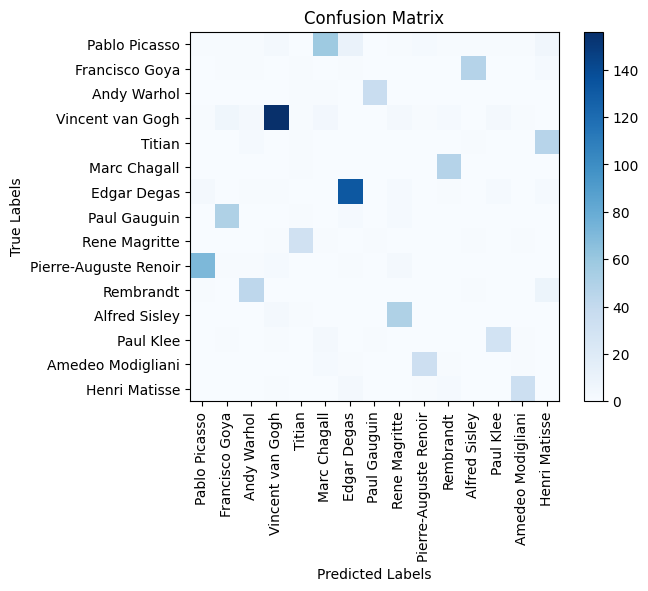

In [ ]:
print("Accuracy:", accuracy)
print("Confusion Matrix:")
unique_types = test_dataset.getUniqueTypes()
num_classes = test_dataset.getNumLabels()
tick_locations = range(len(unique_types))

plt.imshow(confusion_matrix_data, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.colorbar()

plt.xticks(tick_locations, unique_types, rotation='vertical')
plt.yticks(tick_locations, unique_types)

let's further train for another 5 epochs

In [ ]:
model_train(model_xception, train_dataset, val_dataset, loss_xception, n_epochs = 5, save_interval = 1, load_path = MODEL_PATH['MODEL_SAVE_PATH4'], save_path=MODEL_PATH['MODEL_SAVE_PATH4'])

Epoch 1/5:   0%|          | 0/93 [00:00<?, ?it/s]

Validation Loss: 9.867 | Validation Accuracy: 18.044%


Epoch 2/5:   0%|          | 0/93 [00:00<?, ?it/s]

Validation Loss: 10.002 | Validation Accuracy: 18.952%


Epoch 3/5:   0%|          | 0/93 [00:00<?, ?it/s]

Validation Loss: 11.165 | Validation Accuracy: 13.508%


Epoch 4/5:   0%|          | 0/93 [00:00<?, ?it/s]

Validation Loss: 11.057 | Validation Accuracy: 19.052%


Epoch 5/5:   0%|          | 0/93 [00:00<?, ?it/s]

Validation Loss: 9.986 | Validation Accuracy: 17.641%


In [ ]:
model_xception, loss_xception = model_setup(current_dataset = train_dataset, LOAD_PATH= MODEL_PATH['MODEL_SAVE_PATH4'], model_type = 'xceptiondense')
accuracy, confusion_matrix_data = evaluate(model_xception, test_dataset)

Output hidden; open in https://colab.research.google.com to view.

Accuracy: 0.3175403225806452
Confusion Matrix:


([<matplotlib.axis.YTick at 0x7b82942285e0>,
 [Text(0, 0, 'Pablo Picasso'),
  Text(0, 1, 'Francisco Goya'),
  Text(0, 2, 'Andy Warhol'),
  Text(0, 3, 'Vincent van Gogh'),
  Text(0, 4, 'Titian'),
  Text(0, 5, 'Marc Chagall'),
  Text(0, 6, 'Edgar Degas'),
  Text(0, 7, 'Paul Gauguin'),
  Text(0, 8, 'Rene Magritte'),
  Text(0, 9, 'Pierre-Auguste Renoir'),
  Text(0, 10, 'Rembrandt'),
  Text(0, 11, 'Alfred Sisley'),
  Text(0, 12, 'Paul Klee'),
  Text(0, 13, 'Amedeo Modigliani'),
  Text(0, 14, 'Henri Matisse')])

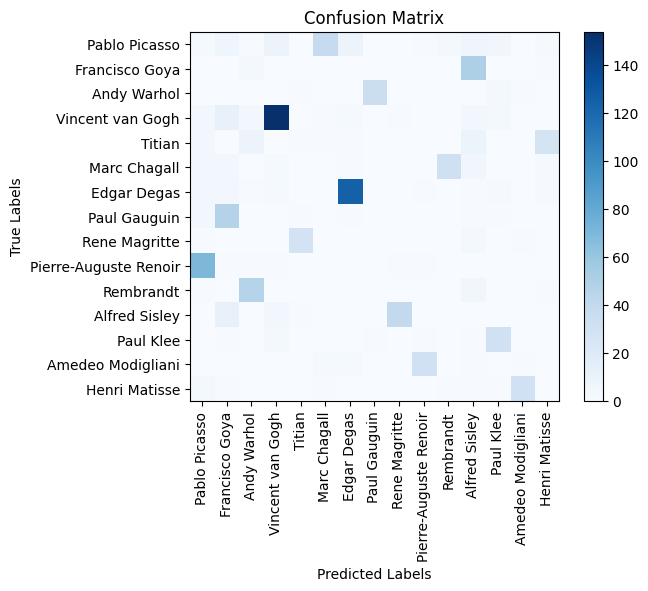

In [ ]:
print("Accuracy:", accuracy)
print("Confusion Matrix:")
unique_types = test_dataset.getUniqueTypes()
num_classes = test_dataset.getNumLabels()
tick_locations = range(len(unique_types))

plt.imshow(confusion_matrix_data, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.colorbar()

plt.xticks(tick_locations, unique_types, rotation='vertical')
plt.yticks(tick_locations, unique_types)

# Training to classify Genre Styles

In the world of art, predicting a painting's genre styles is also a great challenge. Hence, let's first use the inception model to classify styles.

## Inception model

A self defined model that is similar to the structure of Google's inception model

In [ ]:
# Get the dataframe from google drive that we last saved
# Load the dataset
genredataframe = pd.read_csv(f"{DATASET_PATH}/genre_to_path.csv")

In [ ]:
# Split the panda dataframe into train_pd and test_pd
random_state = 4471
train_df, test_df = train_test_split(genredataframe, test_size=0.2, random_state=random_state)

In [ ]:
train_dataset, test_dataset = prepare_datasets(training_df = train_df, testing_df = test_df)

In [ ]:
# Let's run another model with Inception
model_inception, loss_inception = model_setup(train_dataset, model_type = 'Inception')

Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, None, None, 3)  │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, None, None, 64) │          1,792 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, None, None, 64) │              0 │ conv2d_9[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, None, None, 64) │              0 │ max_pooling2d_3[0][0]  │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_10 (Conv2D)        │ (None, None, None, 64) │          4,160 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_11 (Conv2D)        │ (None, None, None, 64) │         36,928 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_12 (Conv2D)        │ (None, None, None, 64) │        102,464 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_13 (Conv2D)        │ (None, None, None, 64) │          4,160 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, None, None,     │              0 │ conv2d_10[0][0],       │
│                           │ 256)                   │                │ conv2d_11[0][0],       │
│                           │                        │                │ conv2d_12[0][0],       │
│                           │                        │                │ conv2d_13[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_5           │ (None, None, None,     │              0 │ concatenate[0][0]      │
│ (MaxPooling2D)            │ 256)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_6           │ (None, None, None,     │              0 │ max_pooling2d_5[0][0]  │
│ (MaxPooling2D)            │ 256)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_14 (Conv2D)        │ (None, None, None,     │         32,896 │ max_pooling2d_5[0][0]  │
│                           │ 128)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_15 (Conv2D)        │ (None, None, None,     │        295,040 │ max_pooling2d_5[0][0]  │
│                           │ 128)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_16 (Conv2D)        │ (None, None, None,     │        819,328 │ max_pooling2d_5[0][0]  │
│                           │ 128)                   │                │                        │
├──────────────────────

 Total params: 1,468,959 (5.60 MB)

 Trainable params: 1,468,959 (5.60 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model_train(model_inception, train_dataset, loss_inception, n_epochs = 50, save_interval = 10, save_path=MODEL_PATH['MODEL_SAVE_PATH2'] )

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

In [ ]:
#In case it crashes let's continue here:
remaining_epoch = 50
model_inception, loss_inception = model_setup(current_dataset = train_dataset, LOAD_PATH= MODEL_PATH['MODEL_SAVE_PATH2'], model_type = 'Inception')
model_train(model_inception, train_dataset, loss_inception, n_epochs = remaining_epoch, save_interval = 10, save_path=MODEL_PATH['MODEL_SAVE_PATH2'],load_path=MODEL_PATH['MODEL_SAVE_PATH2'])

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9             │ (None, None, None, 3)  │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_14 (Conv2D)        │ (None, None, None, 64) │          1,792 │ input_layer_9[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_6           │ (None, None, None, 64) │              0 │ conv2d_14[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_7           │ (None, None, None, 64) │              0 │ max_pooling2d_6[0][0]  │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_15 (Conv2D)        │ (None, None, None, 64) │          4,160 │ max_pooling2d_6[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_16 (Conv2D)        │ (None, None, None, 64) │         36,928 │ max_pooling2d_6[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_17 (Conv2D)        │ (None, None, None, 64) │        102,464 │ max_pooling2d_6[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_18 (Conv2D)        │ (None, None, None, 64) │          4,160 │ max_pooling2d_7[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_2             │ (None, None, None,     │              0 │ conv2d_15[0][0],       │
│ (Concatenate)             │ 256)                   │                │ conv2d_16[0][0],       │
│                           │                        │                │ conv2d_17[0][0],       │
│                           │                        │                │ conv2d_18[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_8           │ (None, None, None,     │              0 │ concatenate_2[0][0]    │
│ (MaxPooling2D)            │ 256)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_9           │ (None, None, None,     │              0 │ max_pooling2d_8[0][0]  │
│ (MaxPooling2D)            │ 256)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_19 (Conv2D)        │ (None, None, None,     │         32,896 │ max_pooling2d_8[0][0]  │
│                           │ 128)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_20 (Conv2D)        │ (None, None, None,     │        295,040 │ max_pooling2d_8[0][0]  │
│                           │ 128)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_21 (Conv2D)        │ (None, None, None,     │        819,328 │ max_pooling2d_8[0][0]  │
│                           │ 128)                   │                │                        │
├──────────────────────

 Total params: 1,468,959 (5.60 MB)

 Trainable params: 1,468,959 (5.60 MB)

 Non-trainable params: 0 (0.00 B)

Weights loaded from /content/drive/MyDrive/comp4211/Project/Model/inception.h5


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

In [ ]:
#TESTING AGAINST TEST DS
model_inception, loss_inception = model_setup(current_dataset = train_dataset, LOAD_PATH= MODEL_PATH['MODEL_SAVE_PATH2'], model_type = 'Inception')
accuracy, confusion_matrix_data = evaluate(model_inception, test_dataset)

Output hidden; open in https://colab.research.google.com to view.

Accuracy: 0.015024038461538462
Confusion Matrix:


([<matplotlib.axis.YTick at 0x7a4a900e68c0>,
 [Text(0, 0, 'Northern Renaissance'),
  Text(0, 1, 'Impressionism,Post-Impressionism'),
  Text(0, 2, 'Impressionism'),
  Text(0, 3, 'Primitivism'),
  Text(0, 4, 'Early Renaissance'),
  Text(0, 5, 'Primitivism,Surrealism'),
  Text(0, 6, 'Romanticism'),
  Text(0, 7, 'Expressionism,Abstractionism,Surrealism'),
  Text(0, 8, 'Realism,Impressionism'),
  Text(0, 9, 'Suprematism'),
  Text(0, 10, 'Surrealism'),
  Text(0, 11, 'Post-Impressionism'),
  Text(0, 12, 'Symbolism,Post-Impressionism'),
  Text(0, 13, 'Mannerism'),
  Text(0, 14, 'Cubism'),
  Text(0, 15, 'High Renaissance'),
  Text(0, 16, 'Baroque'),
  Text(0, 17, 'Neoplasticism'),
  Text(0, 18, 'High Renaissance,Mannerism'),
  Text(0, 19, 'Symbolism'),
  Text(0, 20, 'Abstract Expressionism'),
  Text(0, 21, 'Expressionism'),
  Text(0, 22, 'Social Realism,Muralism'),
  Text(0, 23, 'Surrealism,Impressionism'),
  Text(0, 24, 'Realism'),
  Text(0, 25, 'Pop Art'),
  Text(0, 26, 'Symbolism,Art Nouveau

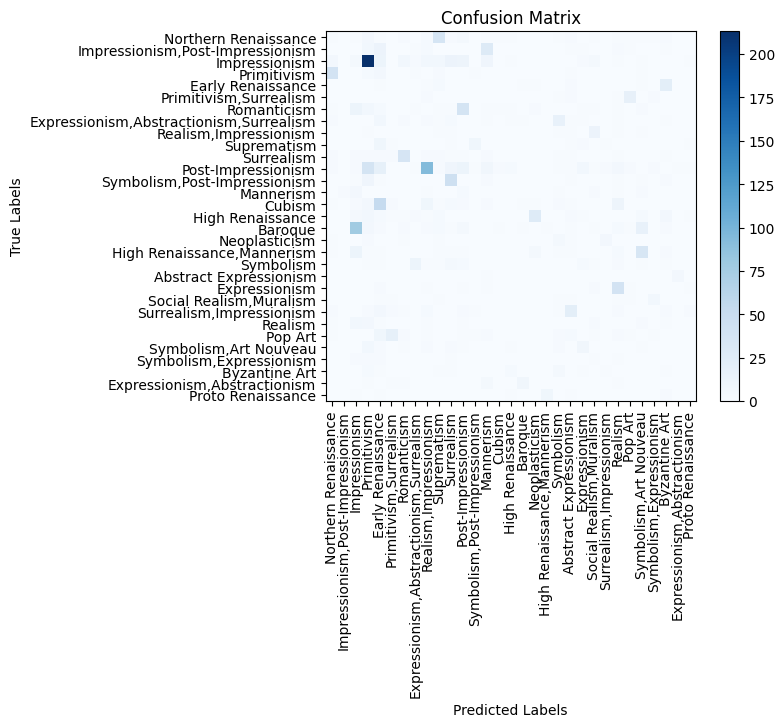

In [ ]:
print("Accuracy:", accuracy)
print("Confusion Matrix:")
unique_types = test_dataset.getUniqueTypes()
num_classes = test_dataset.getNumLabels()
tick_locations = range(len(unique_types))

plt.imshow(confusion_matrix_data, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.colorbar()

plt.xticks(tick_locations, unique_types, rotation='vertical')
plt.yticks(tick_locations, unique_types)

### Data Augmentation

In [9]:
# Update genre groups with overlapping genre assignments
genre_groups = {
    'Renaissance': ['Early Renaissance', 'High Renaissance', 'Proto Renaissance', 'Northern Renaissance'],
    'Impressionism': ['Impressionism', 'Post-Impressionism', 'Impressionism,Post-Impressionism', 'Realism,Impressionism', 'Surrealism,Impressionism'],
    'Expressionism': ['Expressionism', 'Expressionism,Abstractionism,Surrealism', 'Symbolism,Expressionism', 'Expressionism,Abstractionism'],
    'Surrealism': ['Surrealism', 'Primitivism,Surrealism', 'Expressionism,Abstractionism,Surrealism', 'Surrealism,Impressionism', 'Primitivism'],
    'Symbolism': ['Symbolism', 'Symbolism,Post-Impressionism', 'Symbolism,Art Nouveau'],
    'Realism': ['Realism', 'Social Realism,Muralism'],
    'Romanticism': ['Romanticism'],
    'Suprematism': ['Suprematism'],
    'Mannerism': ['Mannerism', 'High Renaissance,Mannerism'],
    'Cubism': ['Cubism'],
    'Baroque': ['Baroque'],
    'Neoplasticism': ['Neoplasticism'],
    'Abstract Expressionism': ['Abstract Expressionism'],
    'Pop Art': ['Pop Art'],
    'Byzantine Art': ['Byzantine Art']
}

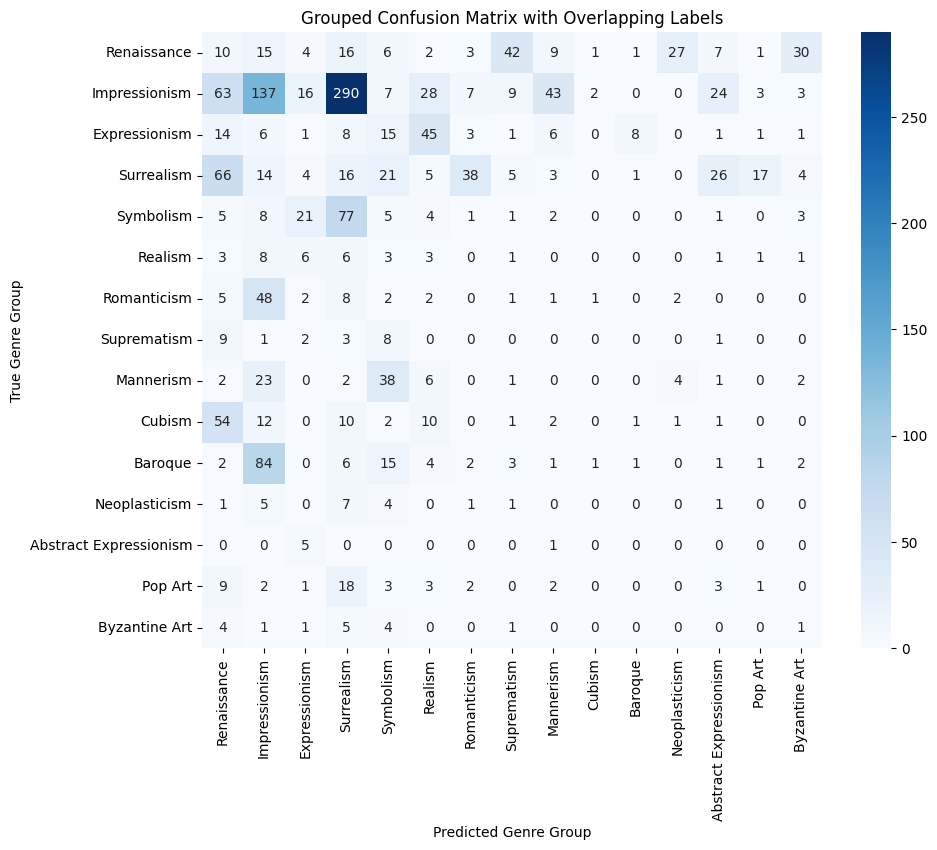

Accuracy: 0.09853603603603604


In [ ]:
# Reverse map for quick lookup
label_to_group = {}
for group, labels in genre_groups.items():
    for label in labels:
        if label not in label_to_group:
            label_to_group[label] = []
        label_to_group[label].append(group)

# Function to map label to group, updating confusion matrix
def map_to_group(true_label, pred_label):
    true_groups = label_to_group.get(true_label, [true_label])
    pred_groups = label_to_group.get(pred_label, [pred_label])
    return true_groups, pred_groups

# Compute new confusion matrix with overlaps
def compute_grouped_confusion_matrix(confusion_matrix_data, labels):
    num_groups = len(genre_groups)
    grouped_confusion_matrix = np.zeros((num_groups, num_groups), dtype=np.int32)
    group_indices = {group: i for i, group in enumerate(genre_groups)}

    for i, true_label in enumerate(labels):
        for j, pred_label in enumerate(labels):
            true_groups, pred_groups = map_to_group(true_label, pred_label)
            for true_group in true_groups:
                for pred_group in pred_groups:
                    if true_group in group_indices and pred_group in group_indices:
                        grouped_confusion_matrix[group_indices[true_group], group_indices[pred_group]] += confusion_matrix_data[i, j]

    return grouped_confusion_matrix

grouped_confusion_matrix = compute_grouped_confusion_matrix(confusion_matrix_data, unique_types)

plt.figure(figsize=(10, 8))
sns.heatmap(grouped_confusion_matrix, annot=True, fmt="d",
            xticklabels=list(genre_groups.keys()),
            yticklabels=list(genre_groups.keys()),
            cmap="Blues", cbar=True)
plt.title("Grouped Confusion Matrix with Overlapping Labels")
plt.xlabel("Predicted Genre Group")
plt.ylabel("True Genre Group")
plt.show()

correct_predictions = np.trace(grouped_confusion_matrix)  # Sum of diagonal elements
total_predictions = np.sum(grouped_confusion_matrix)      # Sum of all elements

accuracy = correct_predictions / total_predictions
print("Accuracy:", accuracy)

So during this what do we realize? That Inception and DenseNet does not work well on recognizing styles. And some styles might overlap as artists may have overlapping styles.

Hence, in the further project, we will use Vision Transformers to work on recognizing styles, and preprocessing images before training. But now, let's try to predict artists.

## Vision Transformers

Let's train on the entire dataset based on the redefined genres above

### ViT Dataset setup

As ViT takes in tensors instead of self defined objects/classes, we will reprocess the data again

In [4]:
def dataset_from_dataframe(df, image_column, label_column, class_len, batch_size=32):
    # Function to process each image
    def process_image(image_path, label):
        # Read image file
        image = tf.io.read_file(image_path)
        image = tf.image.decode_jpeg(image, channels=3)
        image = tf.image.resize(image, [224, 224])  # Resize image to (224, 224) for ViT
        image = image / 255.0  # Normalize the image to [0, 1]
        image = tf.transpose(image, perm=[2, 0, 1])

        # One-hot encoding of labels
        label = tf.cast(label, tf.int32)  # Ensure label is int32
        label = tf.one_hot(label, depth=len(class_len))  # One-hot encode the label
        return image, label

    # Convert labels to indices
    label_to_index = {label: idx for idx, label in enumerate(class_len)}
    labels = df[label_column].map(label_to_index).values  # Map string labels to integer indices

    # Get image paths from DataFrame
    image_paths = df[image_column].values

    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    dataset = dataset.map(process_image, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

Reverse the image processing function

In [5]:
def reverse_process_image(image):
    image = image * 255.0
    image = tf.transpose(image, perm=[1, 2, 0])
    image = tf.clip_by_value(image, 0, 255)
    image = tf.cast(image, tf.uint8)
    return image


In [6]:
# Plot the images with their predicted and true labels
def plot_images(images, true_labels, predicted_labels, class_names, num_images=5):
    plt.figure(figsize=(20, 20))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(reverse_process_image(images[i]))
        true_label = class_names[true_labels[i]]
        predicted_label = class_names[predicted_labels[i]]
        plt.title(f"True: {true_label}\nPred: {predicted_label}")
        plt.axis('off')
    plt.show()


### Train on entire dataset
since the transformer model isn't the same as functions before, preprocessing has to be defined

In [7]:
# Get the dataframe from google drive that we last saved
# Load the dataset
genredataframe = pd.read_csv(f"{DATASET_PATH}/genre_to_path.csv")

In [10]:
# utilizing the genre groups defined above, let's augment the data that we have
def map_to_genre_group(genre):
    for group, genres in genre_groups.items():
        if genre in genres:
            return group

genredataframe['label'] = genredataframe['label'].apply(map_to_genre_group)
genre_counts = genredataframe['label'].value_counts()
genre_list = genre_counts.index.tolist()

print(f"All Genres: {genre_list}")

All Genres: ['Impressionism', 'Renaissance', 'Surrealism', 'Symbolism', 'Baroque', 'Expressionism', 'Cubism', 'Romanticism', 'Mannerism', 'Pop Art', 'Realism', 'Suprematism', 'Byzantine Art', 'Neoplasticism', 'Abstract Expressionism']


In [11]:
# Split the panda dataframe into train_pd and test_pd
random_state = 4471
train_df, test_df = train_test_split(genredataframe, test_size=0.2, random_state=random_state)

# Further split the training+validation set into training and validation sets
train_df, val_df = train_test_split(train_df, test_size=0.25, random_state=random_state)  # 0.25 x 0.8 = 0.2

In [12]:
train_dataset_tf = dataset_from_dataframe(train_df, class_len = genre_list, image_column='image_path', label_column='label')
val_dataset_tf = dataset_from_dataframe(val_df, class_len = genre_list,image_column='image_path', label_column='label')
test_dataset_tf = dataset_from_dataframe(test_df, class_len = genre_list,image_column='image_path', label_column='label')

In [13]:
# Load Pre-trained Vision Transformer
vit_model = TFViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224-in21k',
    num_labels=len(genre_list),
    problem_type="single_label_classification"
)

# Define the optimizer
optimizer = AdamWeightDecay(
    learning_rate=1e-4,
    weight_decay_rate=1e-5
)

# Compile the model
vit_model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)
vit_model.summary()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFViTForImageClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing TFViTForImageClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFViTForImageClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFViTForImageClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_vi_t_for_image_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit (TFViTMainLayer)        multiple                  85798656  
                                                                 
 classifier (Dense)          multiple                  11535     
                                                                 
Total params: 85810191 (327.34 MB)
Trainable params: 85810191 (327.34 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [44]:
# Train the model
main_vit = vit_model.fit(
    train_dataset_tf,
    validation_data=val_dataset_tf,
    epochs=10,
    batch_size=32
)

Epoch 1/10
124/124 [==============================] - 131s 870ms/step - loss: 1.5380 - accuracy: 0.5346 - val_loss: 1.0679 - val_accuracy: 0.6771
Epoch 2/10
124/124 [==============================] - 21s 168ms/step - loss: 0.8303 - accuracy: 0.7636 - val_loss: 0.9937 - val_accuracy: 0.6778
Epoch 3/10
124/124 [==============================] - 21s 168ms/step - loss: 0.4475 - accuracy: 0.8786 - val_loss: 0.6771 - val_accuracy: 0.7888
Epoch 4/10
124/124 [==============================] - 21s 167ms/step - loss: 0.2512 - accuracy: 0.9346 - val_loss: 0.9139 - val_accuracy: 0.7432
Epoch 5/10
124/124 [==============================] - 21s 167ms/step - loss: 0.1531 - accuracy: 0.9612 - val_loss: 0.6174 - val_accuracy: 0.8252
Epoch 6/10
124/124 [==============================] - 21s 167ms/step - loss: 0.0789 - accuracy: 0.9828 - val_loss: 0.6480 - val_accuracy: 0.8169
Epoch 7/10
124/124 [==============================] - 21s 167ms/step - loss: 0.0455 - accuracy: 0.9916 - val_loss: 0.7017 - val_a

NameError: name 'MODEL_PATH6' is not defined

In [46]:
# Save the model
vit_model.save(MODEL_PATH["MODEL_SAVE_PATH6"])

/usr/local/lib/python3.10/dist-packages/transformers/generation/tf_utils.py:465: UserWarning: `seed_generator` is deprecated and will be removed in a future version.
  warnings.warn("`seed_generator` is deprecated and will be removed in a future version.", UserWarning)


In [47]:
test_loss, test_acc = vit_model.evaluate(test_dataset_tf)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

42/42 [==============================] - 28s 655ms/step - loss: 0.7558 - accuracy: 0.8176
Test Accuracy: 81.76%


In [48]:
# Get a batch of images and labels from the test dataset
test_images, test_labels = next(iter(test_dataset_tf))

# Make predictions using the model
predictions = vit_model.predict(test_images)
logits = predictions.logits
predicted_classes = np.argmax(logits, axis=-1)
true_classes = np.argmax(test_labels.numpy(), axis=-1)

print("Predicted Classes:", predicted_classes)
print("True Classes:", true_classes)


1/1 [==============================] - 2s 2s/step
Predicted Classes: [4 6 0 0 1 0 6 0 1 0 2 0 0 0 3 2 1 0 5 0 0 0 1 0 3 0 0 0 0 0 0 2]
True Classes: [4 0 0 2 1 4 6 0 1 5 2 0 0 0 7 2 4 0 5 0 0 0 1 0 3 3 0 0 0 0 0 2]


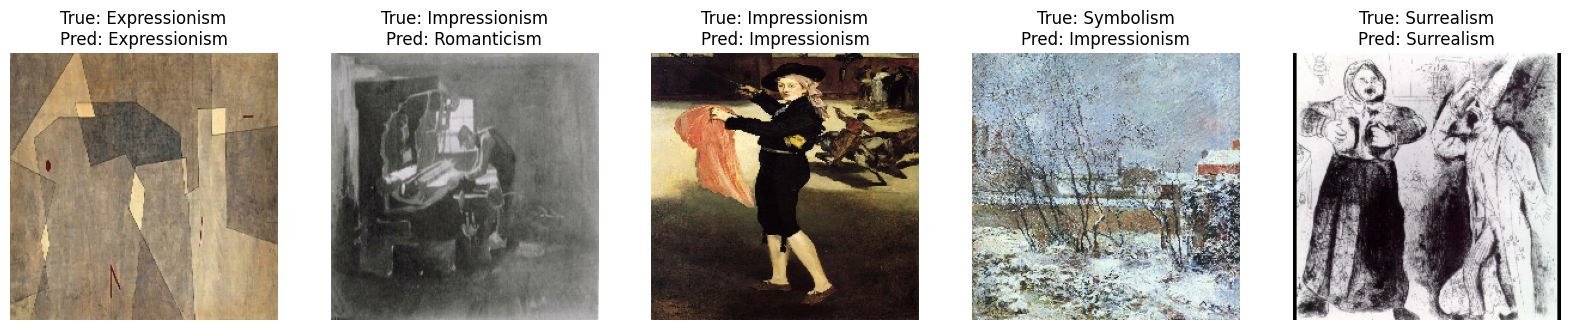

In [49]:
class_names = genre_counts.index.tolist()
plot_images(test_images, true_classes, predicted_classes, class_names)

### Data Augmentation

Acknowledging that there is imbalance in data, as well as style similarty across different artists, we utilize the redefined genre groups above, and opt for the top 8 styles.

In [35]:
top_8_genres = genre_counts.head(8).index.tolist()

print(f"Top 8 Genres: {top_8_genres}")

Top 8 Genres: ['Impressionism', 'Surrealism', 'Symbolism', 'Baroque', 'Expressionism', 'Cubism', 'Romanticism', 'Mannerism']


In [36]:
filtered_genredataframe = genredataframe[genredataframe['label'].isin(top_8_genres)]

In [37]:
# Split the panda dataframe into train_pd and test_pd
random_state = 4471
train_df, test_df = train_test_split(filtered_genredataframe, test_size=0.2, random_state=random_state)

# Further split the training+validation set into training and validation sets
train_df, val_df = train_test_split(train_df, test_size=0.25, random_state=random_state)  # 0.25 x 0.8 = 0.2

In [38]:
# Load Pre-trained Vision Transformer
vit_model = TFViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224-in21k',
    num_labels=len(top_8_genres),
    problem_type="single_label_classification"
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFViTForImageClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing TFViTForImageClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFViTForImageClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFViTForImageClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [40]:
train_dataset_tf = dataset_from_dataframe(train_df, class_len=top_8_genres, image_column='image_path', label_column='label')
val_dataset_tf = dataset_from_dataframe(val_df, class_len=top_8_genres,image_column='image_path', label_column='label')
test_dataset_tf = dataset_from_dataframe(test_df, class_len=top_8_genres,image_column='image_path', label_column='label')


In [129]:
print(f"Number of batches in training dataset: {len(train_dataset_tf)}")
print(f"Number of batches in validation dataset: {len(val_dataset_tf)}")
print(train_dataset_tf)

Number of batches in training dataset: 135
Number of batches in validation dataset: 45
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 3, 224, 224), dtype=tf.float32, name=None), TensorSpec(shape=(None, 8), dtype=tf.float32, name=None))>


In [130]:
for image, label in val_dataset_tf.take(1):  # Take one batch from validation set
    print(f"Sample label: {image.shape}")
    predictions = vit_model(image, training=False)


Sample label: (32, 3, 224, 224)


In [131]:
# Train the model
history = vit_model.fit(
    train_dataset_tf,
    validation_data=val_dataset_tf,
    epochs=10,
    batch_size=32
)

# Save the model
vit_model.save(MODEL_PATH[MODEL_PATH5])

Epoch 1/10
135/135 [==============================] - 270s 2s/step - loss: 1.3363 - accuracy: 0.5712 - val_loss: 0.9830 - val_accuracy: 0.6892
Epoch 2/10
135/135 [==============================] - 23s 168ms/step - loss: 0.6280 - accuracy: 0.8199 - val_loss: 0.7216 - val_accuracy: 0.7721
Epoch 3/10
135/135 [==============================] - 23s 169ms/step - loss: 0.3054 - accuracy: 0.9191 - val_loss: 0.6268 - val_accuracy: 0.8105
Epoch 4/10
135/135 [==============================] - 23s 168ms/step - loss: 0.2067 - accuracy: 0.9447 - val_loss: 0.6526 - val_accuracy: 0.8028
Epoch 5/10
135/135 [==============================] - 23s 168ms/step - loss: 0.1091 - accuracy: 0.9740 - val_loss: 0.6765 - val_accuracy: 0.8174
Epoch 6/10
135/135 [==============================] - 23s 168ms/step - loss: 0.0709 - accuracy: 0.9830 - val_loss: 0.5216 - val_accuracy: 0.8523
Epoch 7/10
135/135 [==============================] - 23s 168ms/step - loss: 0.0376 - accuracy: 0.9919 - val_loss: 0.8001 - val_accu

/usr/local/lib/python3.10/dist-packages/transformers/generation/tf_utils.py:465: UserWarning: `seed_generator` is deprecated and will be removed in a future version.
  warnings.warn("`seed_generator` is deprecated and will be removed in a future version.", UserWarning)


In [ ]:
# vit_model = TFViTForImageClassification.from_pretrained(MODEL_PATH["MODEL_SAVE_PATH5"])

In [134]:
test_loss, test_acc = vit_model.evaluate(test_dataset_tf)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

45/45 [==============================] - 99s 2s/step - loss: 0.8132 - accuracy: 0.8063
Test Accuracy: 80.63%


In [142]:
# Get a batch of images and labels from the test dataset
test_images, test_labels = next(iter(test_dataset_tf))

# Make predictions using the model
predictions = vit_model.predict(test_images)
logits = predictions.logits
predicted_classes = np.argmax(logits, axis=-1)
true_classes = np.argmax(test_labels.numpy(), axis=-1)

print("Predicted Classes:", predicted_classes)
print("True Classes:", true_classes)


1/1 [==============================] - 0s 35ms/step
Predicted Classes: [0 1 3 0 2 2 4 4 6 2 0 6 0 1 0 0 1 0 0 1 4 0 0 5 0 1 2 0 0 3 7 0]
True Classes: [0 1 0 0 2 2 7 4 6 2 0 6 0 6 1 0 1 0 5 1 4 0 0 5 0 1 1 0 0 3 7 3]


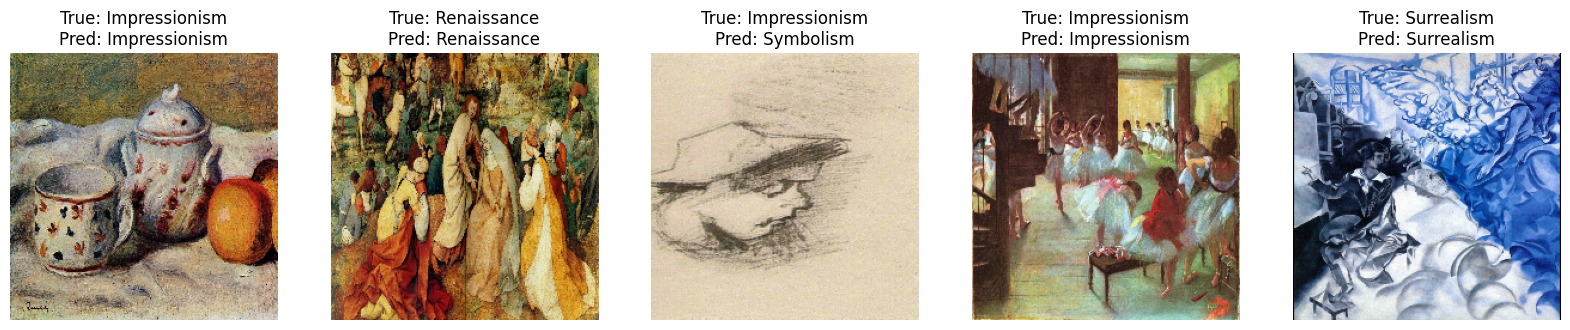

In [144]:
class_names = top_8_genres
plot_images(test_images, true_classes, predicted_classes, class_names)

# Overall Analysis

In the previous sections, we have done data augmentation on the dataset we have. As it is clearly seen, for the same artist, there might be different styles, which will cause distortion in the model. Hence retracting the top most prominent paintings allowed us to make better predictions. On the other hand, some artists have 6-8 times more paintings in our data than others.

Here we would load all the models with their test accuracies and conduct an analysis.

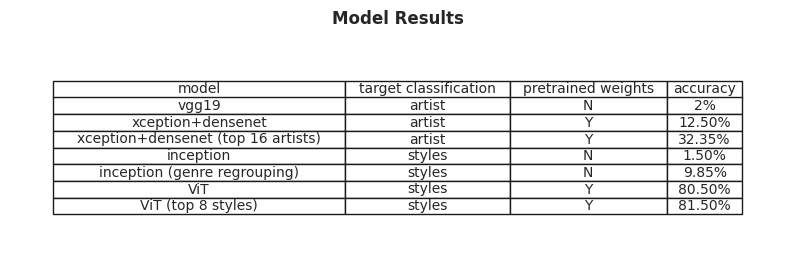

In [57]:
results_df = pd.read_csv(RESULT_PATH)

# Set the style of the plot
sns.set_theme(style="whitegrid")

# Plot the table
fig, ax = plt.subplots(figsize=(10, 3))
ax.axis('tight')
ax.axis('off')
table = plt.table(cellText=results_df.values,
                  colLabels=results_df.columns,
                  cellLoc='center',
                  loc='center',
                  colWidths=[0.15, 0.25, 0.15, 0.15])

table.auto_set_font_size(False)
table.set_fontsize(10)
table.auto_set_column_width(col=list(range(len(results_df.columns))))

plt.title("Model Results", fontsize=12, fontweight='bold')
plt.show()